In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from keras.layers import GRU 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [3]:
exchange_data = pd.read_csv('GBPUSD-4HOUR.csv')
exchange_data.head()



,time,open,high,low,close,Volume,Volume MA
0,2009-12-31T22:00:00Z,1.617570,1.617570,1.615630,1.615630,8,NaN
1,2010-01-03T22:00:00Z,1.611220,1.615290,1.609180,1.609230,4115,NaN
2,2010-01-04T02:00:00Z,1.609230,1.612080,1.607350,1.609630,2782,NaN
3,2010-01-04T06:00:00Z,1.609630,1.621375,1.605795,1.620535,7412,NaN
4,2010-01-04T10:00:00Z,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [4]:
exchange_data["time"] = pd.to_datetime(exchange_data["time"])
ind_exchange_data = exchange_data.set_index(["time"], drop=True)

In [36]:
ind_exchange_data.head()
print(len(ind_exchange_data))

20438


In [263]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=False)

cut_off_date = pd.Timestamp('25-03-20')
data_frame = data_frame.loc[:cut_off_date]
data_frame.tail()



/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_55272/1982042183.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data_frame = data_frame.loc[:cut_off_date]


,open,low,high,close,Volume MA,Volume
time,,,,,,
2020-03-24 05:00:00+00:00,1.16367,1.16040,1.16932,1.16660,21588.95,13255
2020-03-24 09:00:00+00:00,1.16660,1.16494,1.17900,1.17526,22642.95,32981
2020-03-24 13:00:00+00:00,1.17526,1.16962,1.18000,1.17622,23819.75,46171
2020-03-24 17:00:00+00:00,1.17622,1.17126,1.17830,1.17608,22782.95,19049
2020-03-24 21:00:00+00:00,1.17608,1.17405,1.17952,1.17662,20784.35,4009


<AxesSubplot: xlabel='time'>

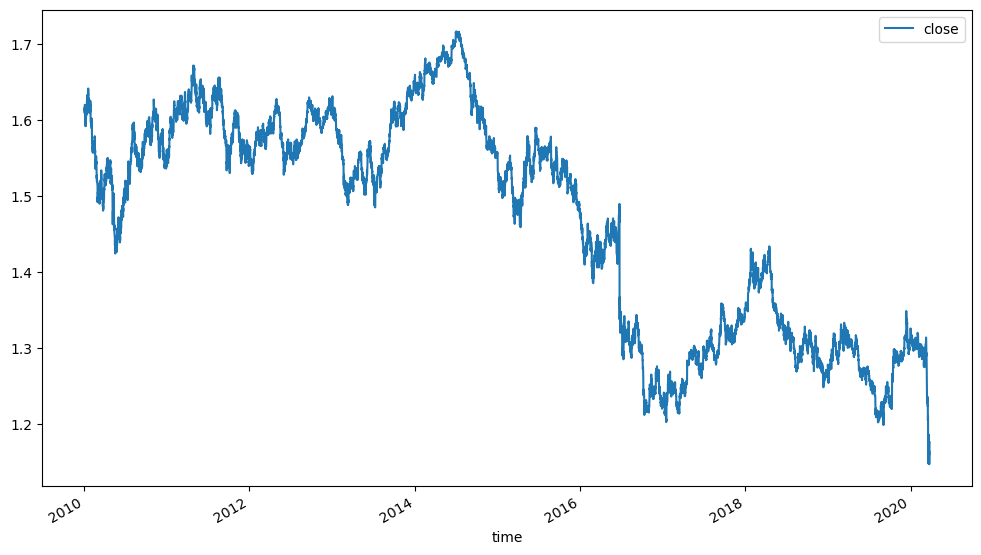

In [264]:
df = data_frame[["close"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [265]:
diff = df.index.values[-1] - df.index.values[0]



days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 10 years
80 percent data = 2010 to 2018


In [266]:
df.describe()

,close
count,15905.000000
mean,1.469079
std,0.143536
min,1.147640
25%,1.312965
50%,1.521615
75%,1.588355
max,1.717000


In [267]:
#deduce the full length of the dataset
print(len(data_frame))

clipped_data_length = len(data_frame)

15905


In [268]:
#deduce where the number where the partition should be made 

adjust_data_frame = np.array(data_frame)
x = int(len(data_frame))
print(x)
split_length = int(x * 0.8)
print(split_length)



15905
12724


In [269]:
split_date = data_frame.index[split_length]
print(data_frame.index[split_length])
print(split_date)

2018-03-07 22:00:00+00:00
2018-03-07 22:00:00+00:00


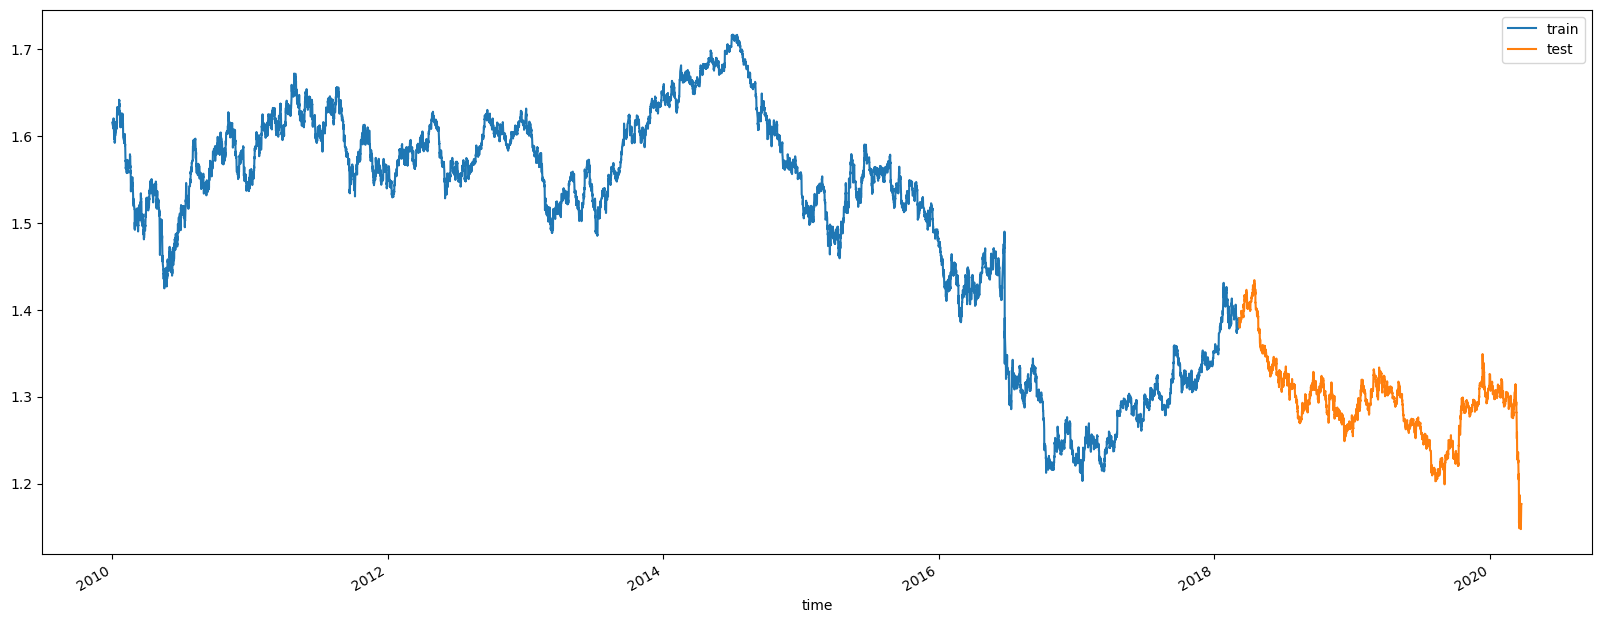

In [270]:
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(20,8))
test.plot(ax=ax,kind='line',figsize=(20,8))
plt.legend(['train', 'test'])

In [271]:
from sklearn.preprocessing import StandardScaler

In [272]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [273]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

print(X_train.shape)

(12724, 1)


In [274]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                24        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [275]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
12724/12724 [==============================] - 4s 291us/step - loss: 0.0061 - rmse: 0.0781
Epoch 2/200
12724/12724 [==============================] - 4s 278us/step - loss: 0.0011 - rmse: 0.0335
Epoch 3/200
12724/12724 [==============================] - 4s 278us/step - loss: 0.0011 - rmse: 0.0327
Epoch 4/200
12724/12724 [==============================] - 4s 284us/step - loss: 0.0010 - rmse: 0.0321
Epoch 5/200
12724/12724 [==============================] - 4s 279us/step - loss: 0.0010 - rmse: 0.0319
Epoch 6/200
12724/12724 [==============================] - 4s 280us/step - loss: 0.0010 - rmse: 0.0318
Epoch 7/200
12724/12724 [==============================] - 4s 280us/step - loss: 9.9545e-04 - rmse: 0.0316
Epoch 8/200
12724/12724 [==============================] - 4s 279us/step - loss: 9.8637e-04 - rmse: 0.0314
Epoch 9/200
12724/12724 [==============================] - 4s 282us/step - loss: 9.7495e-04 - rmse: 0.0312
Epoch 10/200
12724/12724 [==============================] - 4

In [276]:
#y pred_test is the actual ANN predictions
y_pred_test = model.predict(X_test)
y_train_pred = model.predict(y_train)

train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)

test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The  MAE on the Train set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))

print("The  RMSE on the Train set is:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("The  RMSE on the Test set is:\t{:0.3f}".format(rmse_test))



398/398 [==============================] - 0s 228us/step
The R2 score on the Train set is:	0.957
The  MAE on the Train set is:	0.184
The  RMSE on the Train set is:	0.208
The Adjusted R2 score on the Train set is:	0.957

The R2 score on the Test set is:	0.840
The Adjusted R2 score on the Test set is:	0.840
The  MAE on the Test set is:	0.131
The  RMSE on the Test set is:	0.143


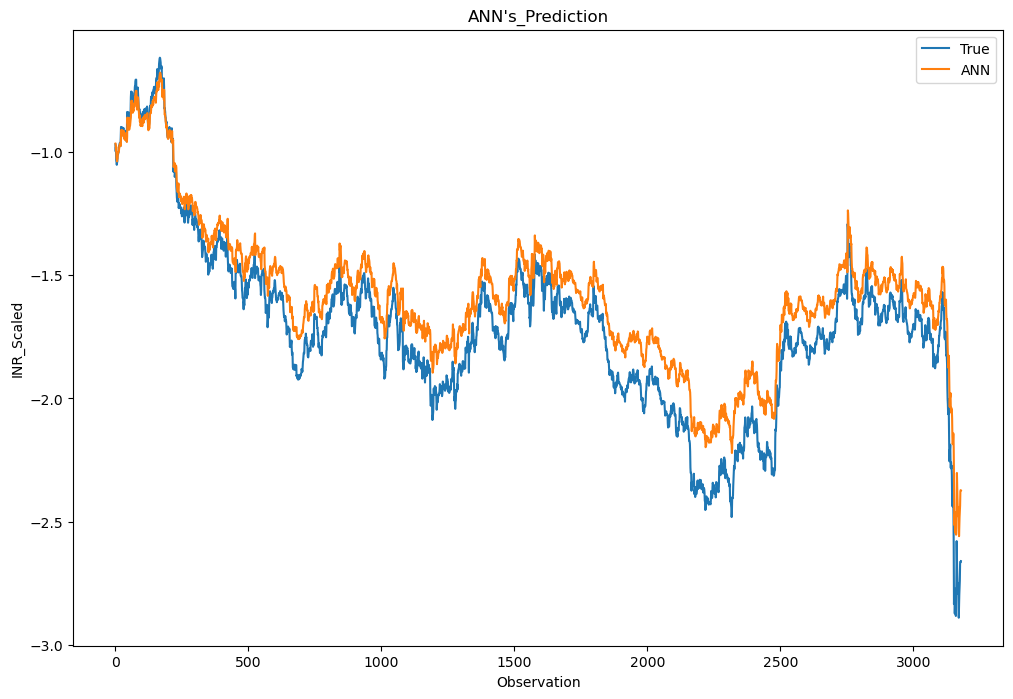

In [277]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [278]:
#Test is with future predictions 


last_value_ann = y_test[-1:]


future_predictions_ann = []
num_steps = 10

for i in range(num_steps):
    prediction_ann = model.predict(last_value_ann.reshape(-1,1))
    
    future_predictions_ann.append(prediction_ann[0][0])
    
    last_value_ann = np.concatenate((last_value_ann[1:], prediction_ann), axis=0)

    
future_predictions_ann = np.array(future_predictions_ann).reshape(-1, 1) 
inverse_transformed_data = sc.inverse_transform(future_predictions_ann).flatten().tolist()
print(inverse_transformed_data)







1/1 [==============================] - 0s 8ms/step
[1.2132844924926758, 1.2436423301696777, 1.2687770128250122, 1.289587140083313, 1.3068169355392456, 1.3210821151733398, 1.3328930139541626, 1.3426718711853027, 1.3507680892944336, 1.3574714660644531]


In [279]:
rounded_numbers = [round(num, 5) for num in inverse_transformed_data]
print(rounded_numbers)

#it doesnt do well when predicting directional change 
        
                   

[1.21328, 1.24364, 1.26878, 1.28959, 1.30682, 1.32108, 1.33289, 1.34267, 1.35077, 1.35747]


In [280]:
X = []
y = []
timesteps = 6

for i in range(timesteps, train.shape[0]):
    X.append(train_sc[i-timesteps:i, 0])
    y.append(train_sc[i, 0])



X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(X.shape)
print(y.shape)





(12719, 6, 1)
(12719,)


In [281]:
K.clear_session()

#model_lstm = tf.keras.Sequential([
#    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)),
#    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
#    tf.keras.layers.MaxPooling1D(pool_size=2),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(units=64, activation='relu'),
#    tf.keras.layers.Dense(units=1, activation='linear')
#])


#Convolutional followed by lstm does pretty for short term predictions, this one got the n+1 iteration perfectly right 

#model_lstm = tf.keras.Sequential([
#    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)),
#    tf.keras.layers.MaxPooling1D(pool_size=2),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.LSTM(50, return_sequences=True),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(units=1, activation='linear')
#])


#LSTM GRU CNN
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(6, 1)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='linear')
])




#We need to start looking at echo state networks 





In [282]:
model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm = model_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
67/67 [==============================] - 2s 7ms/step - loss: 0.1049 - rmse: 0.3239
Epoch 2/100
67/67 [==============================] - 1s 8ms/step - loss: 0.1327 - rmse: 0.3643
Epoch 3/100
67/67 [==============================] - 1s 8ms/step - loss: 0.1378 - rmse: 0.3712
Epoch 4/100
67/67 [==============================] - 1s 8ms/step - loss: 0.0851 - rmse: 0.2916
Epoch 5/100
67/67 [==============================] - 1s 8ms/step - loss: 0.0573 - rmse: 0.2394
Epoch 6/100
67/67 [==============================] - 1s 8ms/step - loss: 0.0395 - rmse: 0.1987
Epoch 7/100
67/67 [==============================] - 1s 8ms/step - loss: 0.0297 - rmse: 0.1723
Epoch 8/100
67/67 [==============================] - 1s 8ms/step - loss: 0.0298 - rmse: 0.1725
Epoch 9/100
67/67 [==============================] - 1s 8ms/step - loss: 0.0295 - rmse: 0.1717
Epoch 10/100
67/67 [==============================] - 1s 8ms/step - loss: 0.0304 - rmse: 0.1745
Epoch 11/100
67/67 [=============================

In [283]:
X_test_lstm = []
Y_test_lstm = []

for i in range(timesteps, test.shape[0]):
    X_test_lstm.append(test_sc[i-timesteps:i, 0])
    Y_test_lstm.append(test_sc[i, 0])

    
X_test_lstm = np.array(X_test_lstm)
Y_test_lstm = np.array(Y_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

y_pred_test_lstm = model_lstm.predict(X_test_lstm)









100/100 [==============================] - 1s 979us/step


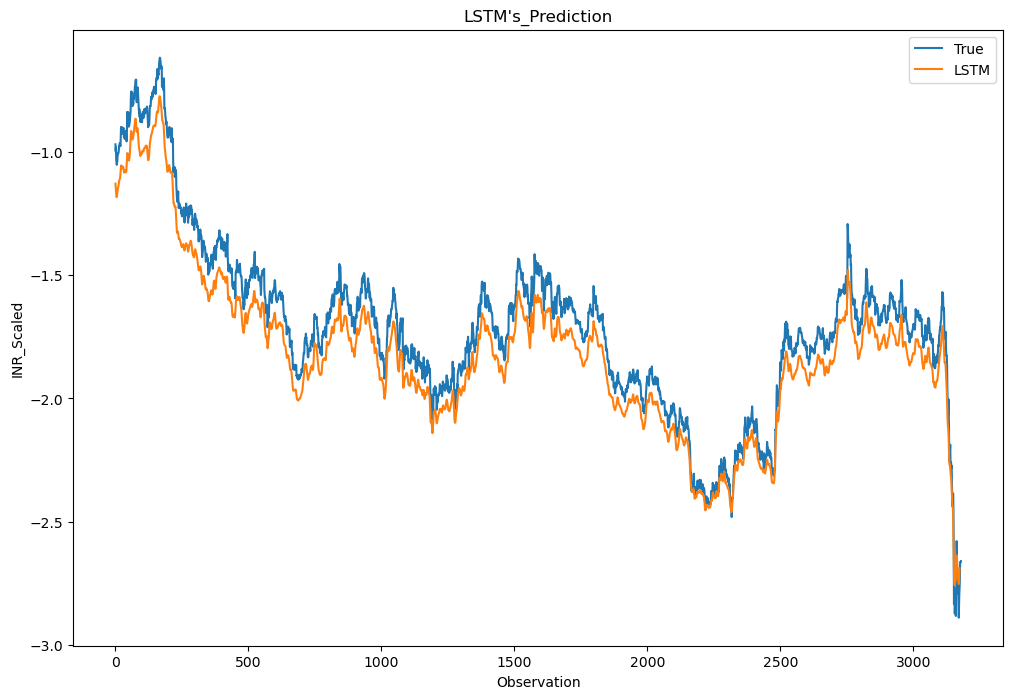

In [284]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [285]:
last_prediction = y_pred_test_lstm[-timesteps:]
last_prediction = np.array(last_prediction)

for i in range(10):
    next_input = np.array([last_prediction[-timesteps:]])
    next_input = next_input.reshape((next_input.shape[0], next_input.shape[1], 1))
    next_prediction = model_lstm.predict(next_input, verbose=0)
    last_prediction = np.append(last_prediction, next_prediction[0])
    

print(sc.inverse_transform(test_sc[-2:]))
lstm_future = np.array(last_prediction[-10:]).reshape(-1,1)

inverse_transformed_data_lstm = sc.inverse_transform(lstm_future).flatten().tolist()
print(inverse_transformed_data_lstm)







[[1.17608]
 [1.17662]]
[1.1726230382919312, 1.1729589700698853, 1.1741561889648438, 1.1757335662841797, 1.1771408319473267, 1.1779718399047852, 1.1785366535186768, 1.1793962717056274, 1.1803549528121948, 1.1812108755111694]


In [286]:
lstm_rounded_numbers = [round(x, 5) for x in inverse_transformed_data_lstm]
print(lstm_rounded_numbers)
print(sc.inverse_transform(y_pred_test_lstm[-1:]))

[1.17262, 1.17296, 1.17416, 1.17573, 1.17714, 1.17797, 1.17854, 1.1794, 1.18035, 1.18121]
[[1.1729218]]


In [287]:
future_lstm_prices = []
last_lstm = sc.inverse_transform(y_pred_test_lstm[-1:])
future_lstm_prices.append(round(float(last_lstm[0]),5))
for x in lstm_rounded_numbers:
    future_lstm_prices.append(x)                     

In [288]:

print(clipped_data_length)
future_comparison = ind_exchange_data.iloc[clipped_data_length:]

print(future_comparison.head())

15905
                              open     high      low    close  Volume  \
time                                                                    
2020-03-25 01:00:00+00:00  1.17662  1.18172  1.17648  1.18039    5570   
2020-03-25 05:00:00+00:00  1.18039  1.19288  1.17952  1.19232   15427   
2020-03-25 09:00:00+00:00  1.19232  1.19738  1.18260  1.18358   30530   
2020-03-25 13:00:00+00:00  1.18358  1.18460  1.16392  1.18356   53620   
2020-03-25 17:00:00+00:00  1.18356  1.19166  1.17928  1.18801   22346   

                           Volume MA  
time                                  
2020-03-25 01:00:00+00:00   19783.10  
2020-03-25 05:00:00+00:00   20259.95  
2020-03-25 09:00:00+00:00   21424.80  
2020-03-25 13:00:00+00:00   22992.85  
2020-03-25 17:00:00+00:00   22702.15  


In [289]:
future = future_comparison.iloc[1:10]

future_prices_table = future["close"]

future_prices = []
for x in future_prices_table:
    future_prices.append(x)

print(future_prices)

[1.19232, 1.18358, 1.18356, 1.18801, 1.18671, 1.18564, 1.19214, 1.19879, 1.2172]


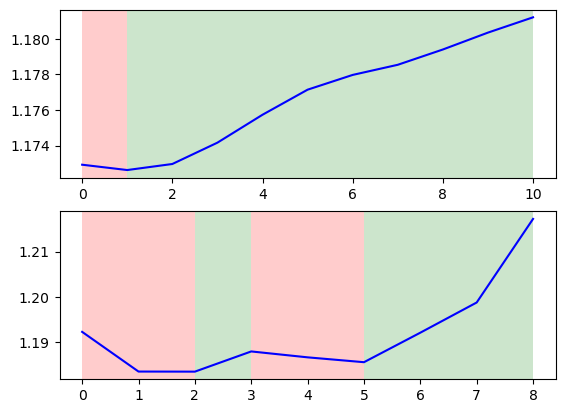

In [290]:
import matplotlib.pyplot as plt



def classify_numbers(lst):
    classifications = []
    prev_num = lst[0]
    for i, num in enumerate(lst[1:], start=1):
        if num > prev_num:
            classifications.append('green')
        else:
            classifications.append('red')
        prev_num = num
    return classifications

classifications1 = classify_numbers(future_lstm_prices)
classifications2 = classify_numbers(future_prices)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(future_lstm_prices, color='blue')
for i, c in enumerate(classifications1):
    if c == 'green':
        ax1.axvspan(i, i+1, facecolor='green', alpha=0.2)
    elif c == 'red':
        ax1.axvspan(i, i+1, facecolor='red', alpha=0.2)

ax2.plot(future_prices, color='blue')
for i, c in enumerate(classifications2):
    if c == 'green':
        ax2.axvspan(i, i+1, facecolor='green', alpha=0.2)
    elif c == 'red':
        ax2.axvspan(i, i+1, facecolor='red', alpha=0.2)

plt.show()



#This may be potientally be abled to be used, it may have not got the correct retracements however it was able to predict the overall direction, 
#say you have had a fib at this level for a potiental buy this fib could be immediately discarded as it will be clear break through, we need to find a potiental change 
#in momentum to be able to predict this. Evaluation wise these model might do well in predictiing overall trend than proper values  

